# Christina Hyman

# CS 668 Capstone Thesis:
The goal of this research project is to perform regression analysis to develop accurate price prediction models for New York City Airbnb listings while identifying the most relevant features that influence the prices of Airbnb listings.

The measurable progress indicator for this project is the development of accurate regression models with high predictive performance for NYC Airbnb listing prices. Key metrics such as mean squared error, root mean square error, and R-squared will quantify the models' performance and effectiveness.

Inside Airbnb provides data on Airbnb listings in New York City on a 12-month rolling period, currently containing data on Airbnb listings from February 2023 to April 2024. 

The datasets include various features of host information, property details/amenities, borough and neighborhood location, longitude and latitude coordinates, customer reviews, and prices for each listing. Incorporating these features will uncover patterns and trends in Airbnb listings, particularly in with pricing dynamics.

This research project will also include a case study to investigate the causal effects of Local Law 18 using a Difference-in-Differences (Diff-in-Diff) model. 


**Data Sources:**
* Airbnb Listings Data: http://insideairbnb.com/get-the-data/
* Transit Data: http://web.mta.info/developers/developer-data-terms.html#data
* Data Dictionary: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing

## Loading  & Formatting Data and Dropping Duplicates

In [1]:
#!pip install geopandas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.metrics.pairwise import haversine_distances
from math import radians, sqrt
import warnings
import geopandas as gpd
from geopandas.datasets import get_path
import geopandas.tools as gpd_tools
from shapely.geometry import Point
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse
import statsmodels.api as sm
from datetime import datetime

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [4]:
df_02_23 = pd.read_csv('airbnb_data_02_23.csv', dtype={'license': 'object'})
df_03_23 = pd.read_csv('airbnb_data_03_23.csv', dtype={'license': 'object'})
df_04_23 = pd.read_csv('airbnb_data_04_23.csv', dtype={'license': 'object'})
df_05_23 = pd.read_csv('airbnb_data_05_23.csv', dtype={'license': 'object'})
df_06_23 = pd.read_csv('airbnb_data_06_23.csv')
df_07_23 = pd.read_csv('airbnb_data_07_23.csv')
df_08_23 = pd.read_csv('airbnb_data_08_23.csv')
df_09_23 = pd.read_csv('airbnb_data_09_23.csv')
df_10_23 = pd.read_csv('airbnb_data_10_23.csv')
df_11_23 = pd.read_csv('airbnb_data_11_23.csv')
df_12_23 = pd.read_csv('airbnb_data_12_23.csv')
df_01_24 = pd.read_csv('airbnb_data_01_24.csv')
df_02_24 = pd.read_csv('airbnb_data_02_24.csv')
df_03_24 = pd.read_csv('airbnb_data_03_24.csv')
df_04_24 = pd.read_csv('airbnb_data_04_24.csv')


frames = [df_02_23, df_03_23, df_04_23, df_05_23, 
          df_06_23, df_07_23, df_08_23, df_09_23, 
          df_10_23, df_11_23, df_12_23, df_01_24,
          df_02_24, df_03_24, df_04_24]

In [5]:
df_original = pd.concat(frames)

In [6]:
df_original.shape

(616740, 75)

**The dataset has 616740 observations and 75 features.**

In [7]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 616740 entries, 0 to 38376
Data columns (total 75 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            616740 non-null  int64  
 1   listing_url                                   616740 non-null  object 
 2   scrape_id                                     616740 non-null  int64  
 3   last_scraped                                  616740 non-null  object 
 4   source                                        616740 non-null  object 
 5   name                                          616691 non-null  object 
 6   description                                   527453 non-null  object 
 7   neighborhood_overview                         356376 non-null  object 
 8   picture_url                                   616740 non-null  object 
 9   host_id                                       616

In [8]:
df_original['last_scraped'] = pd.to_datetime(df_original['last_scraped'])

df_original['date'] = df_original['last_scraped'].dt.strftime('%Y-%m')

df_original['price'] = df_original['price'].replace('[\$,]', '', regex=True).astype(float)

In [9]:
df_original.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [10]:
df_original['id'].nunique()

62872

**There are 62872 unique Airbnb listings in New York City**

In [11]:
df_original.duplicated(subset=['id', 'host_name', 'latitude', 'longitude', 'price']).sum()

365995

In [12]:
df = df_original.drop_duplicates(subset=['id', 'host_name', 'latitude', 'longitude', 'price'])

**Based on the subset of assuming that previous listings appear in later scrapes, 365995 duplicates were found. These observations will be dropped from the DataFrame.**

In [13]:
df.shape

(250745, 76)

**After dropping the duplicates, there are 250745 observations remaining.**

In [14]:
# List of features to be dropped
drop_col = ['id', 'listing_url', 'scrape_id', 'source', 'name', 'description', 'neighborhood_overview',
            'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
            'host_response_time', 'host_response_rate', 'host_thumbnail_url', 'host_picture_url', 
            'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_neighbourhood',
            'neighbourhood', 'property_type', 'bathrooms', 'minimum_minimum_nights', 'maximum_minimum_nights',
            'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
            'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90',
            'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm',
            'number_of_reviews_l30d', 'first_review', 'last_review',  'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
            'review_scores_location', 'review_scores_value', 'license', 'calculated_host_listings_count', 
            'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'last_scraped']

In [15]:
df = df.drop(drop_col, axis=1)
df.shape

(250745, 20)

In [16]:
df.columns

Index(['host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities',
       'price', 'minimum_nights', 'maximum_nights', 'review_scores_rating',
       'instant_bookable', 'date'],
      dtype='object')

**The features stored in `drop_col` are either represented more thoroughly in another feature (repetitive) or are redundant and don't provide insight in the price prediction models. After dropping those columns, there are 20 features remaining**

In [17]:
df.duplicated().sum()

651

In [18]:
df = df.drop_duplicates()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250094 entries, 0 to 38376
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   host_acceptance_rate          219125 non-null  object 
 1   host_is_superhost             235480 non-null  object 
 2   host_listings_count           250073 non-null  float64
 3   host_identity_verified        250073 non-null  object 
 4   neighbourhood_cleansed        250094 non-null  object 
 5   neighbourhood_group_cleansed  250094 non-null  object 
 6   latitude                      250094 non-null  float64
 7   longitude                     250094 non-null  float64
 8   room_type                     250094 non-null  object 
 9   accommodates                  250094 non-null  int64  
 10  bathrooms_text                249822 non-null  object 
 11  bedrooms                      167286 non-null  float64
 12  beds                          239422 non-null

In [20]:
df = df.rename(columns={'neighbourhood_cleansed':'neighborhood', 'neighbourhood_group_cleansed':'borough'})
df['date'] = df['date'].astype('datetime64[ns]')

In [21]:
df.columns

Index(['host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_identity_verified', 'neighborhood', 'borough', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'instant_bookable', 'date'],
      dtype='object')

In [22]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].replace('%', '', regex=True).astype(float)

**In the first of the previous two cells, I rename columns to make it more interperatable and change the `date` type to datatime64.**
**In the previous cell, I format the `price` and `host_acceptance_rate` features to make the floats by removing special characters $,%**

In [23]:
df.loc[:,['date', 'host_acceptance_rate', 'host_is_superhost',
          'host_listings_count', 'host_identity_verified', 'borough', 'latitude',
          'longitude', 'room_type', 'accommodates']].head()

,date,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,borough,latitude,longitude,room_type,accommodates
0,2023-02-01,21.0,f,7.0,t,Manhattan,40.75356,-73.98559,Entire home/apt,1
1,2023-02-01,82.0,t,2.0,t,Brooklyn,40.68535,-73.95512,Private room,2
2,2023-02-01,50.0,f,1.0,t,Brooklyn,40.66265,-73.99454,Entire home/apt,4
3,2023-02-01,82.0,f,1.0,f,Manhattan,40.76076,-73.96156,Entire home/apt,3
4,2023-02-01,NaN,f,1.0,t,Manhattan,40.80380,-73.96751,Private room,1


In [24]:
df.loc[:,['bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
          'minimum_nights', 'maximum_nights', 'review_scores_rating', 
          'instant_bookable']].head()

,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,review_scores_rating,instant_bookable
0,1 bath,NaN,1.0,"[""Keypad"", ""Extra pillows and blankets"", ""TV"",...",150.0,30,1125,4.68,f
1,NaN,1.0,1.0,"[""Kitchen"", ""Wifi"", ""Long term stays allowed"",...",60.0,30,730,4.52,f
2,1.5 baths,2.0,2.0,"[""Carbon monoxide alarm"", ""HDTV with Disney+, ...",275.0,21,1125,5.00,f
3,1 bath,1.0,1.0,"[""Hot water"", ""Essentials"", ""Carbon monoxide a...",295.0,4,1125,4.90,f
4,1 shared bath,1.0,1.0,"[""Hot water"", ""Breakfast"", ""Essentials"", ""Wifi...",75.0,2,14,4.91,f


**In the previous two cells, I take a quick look at what type of values each feature takes.**

## Handling Missing Values

In [25]:
df.isnull().sum()

host_acceptance_rate      30969
host_is_superhost         14614
host_listings_count          21
host_identity_verified       21
neighborhood                  0
borough                       0
latitude                      0
longitude                     0
room_type                     0
accommodates                  0
bathrooms_text              272
bedrooms                  82808
beds                      10672
amenities                     0
price                     17784
minimum_nights                0
maximum_nights                0
review_scores_rating      69037
instant_bookable              0
date                          0
dtype: int64

In [26]:
df = df.dropna(subset=['price'])
df = df[df['price'] != 0]

**Prices that contained NaN or 0's are dropped to avoid manipulating the target feature.**

In [27]:
df.isnull().sum()

host_acceptance_rate      19835
host_is_superhost         14537
host_listings_count          16
host_identity_verified       16
neighborhood                  0
borough                       0
latitude                      0
longitude                     0
room_type                     0
accommodates                  0
bathrooms_text              211
bedrooms                  69722
beds                       3412
amenities                     0
price                         0
minimum_nights                0
maximum_nights                0
review_scores_rating      63116
instant_bookable              0
date                          0
dtype: int64

In [28]:
missing_numeric_cols = ['host_acceptance_rate', 'host_listings_count', 'bedrooms', 'beds', 'review_scores_rating']

for col in missing_numeric_cols:
    df.loc[:, col] = df[col].fillna(df[col].median())

In [29]:
missing_categorical_cols = ['host_is_superhost', 'host_identity_verified', 'bathrooms_text']

for col in missing_categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

**All other features containing NaN are replaced with the median value of each respective feature. This is to help retain as much data as possible.**

In [30]:
df.isnull().sum()

host_acceptance_rate      0
host_is_superhost         0
host_listings_count       0
host_identity_verified    0
neighborhood              0
borough                   0
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
amenities                 0
price                     0
minimum_nights            0
maximum_nights            0
review_scores_rating      0
instant_bookable          0
date                      0
dtype: int64

## Handling Outliers

**A function `detect_outliers` uses the interquartile range method to detect observations that are out of the range +/- 1.5 * Q1 and Q3. The outliers are visualized to see which the degree of skewed data for each feature.**

The bar charts after the `detect_outliers` function visualize the number of outliers of the features that were detected to contain outliers.

The outliers for the `price` feature are removed to avoid manipulating the target feature, and the remaining features are replaced with the median from their respective column. The `latitude` and `longitude` features are left unchanged.

In [31]:
def detect_outliers(df, cols):
    # Create a new DataFrame to store total outlier counts
    df_outliers_count = pd.DataFrame(index=['total_outliers'])

    for col in df.columns:
        if df[col].dtype=='float64' or df[col].dtype=='int64':
            # Calculate quartiles and IQR for the column
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1

            # Identify outliers using the IQR method
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            outliers = ((df[col] < lower) | (df[col] > upper))

            # Count the total number of outliers for each column
            total_outliers = outliers.sum()

            # Store total outlier counts in the new DataFrame
            df_outliers_count[col] = total_outliers

    return df_outliers_count

In [32]:
outlier_detected_cols = ['host_acceptance_rate', 'host_listings_count', 'accommodates', 
                         'bedrooms', 'beds', 'price', 'minimum_nights',
                         'review_scores_rating']
outliers_df = detect_outliers(df, df.columns)

In [33]:
outliers_df

,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,review_scores_rating
total_outliers,22324,44847,3093,16133,12086,59050,18498,16243,2122,13,21981


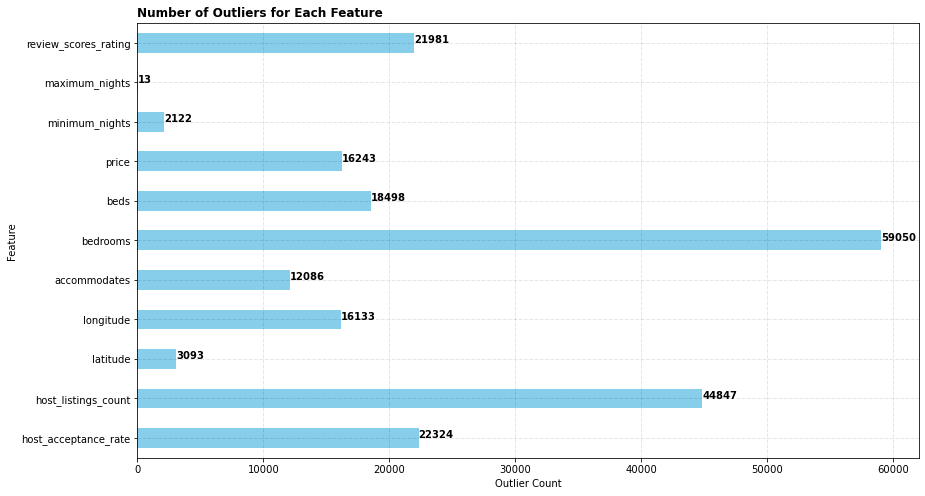

In [34]:
outliers_count = outliers_df.iloc[0]

fig, ax = plt.subplots(figsize=(14, 8))

# Plot outliers
outliers_count.plot(kind='barh', color='skyblue')

# Add gridlines
ax.grid(color='black', linestyle='-.', linewidth=0.5, alpha=0.2)

# Add annotation to bars
for i, v in enumerate(outliers_count):
    plt.text(v + 0.2, i, str(round(v, 2)), fontdict={'fontsize':10, 'fontweight':'bold'})

ax.set_title('Number of Outliers for Each Feature', loc='left', fontweight='bold')

plt.xlabel('Outlier Count')
plt.ylabel('Feature')
plt.show()


In [35]:
def remove_outliers(df, cols):

    # Create a copy of the DataFrame to avoid modifying the original
    df_outliers = df.copy()

    # Iterate for each column
    for col in cols:
        # Save the original dtype
        original_dtype = df_outliers[col].dtype

        # Calculate the upper and lower limits using IQR
        Q1 = df_outliers[col].quantile(0.25)
        Q3 = df_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        # Identify and remove outliers
        outliers = (df_outliers[col] < lower_limit) | (df_outliers[col] > upper_limit)
        df_outliers = df_outliers.loc[~outliers]

        # Assign original dtype back to each column
        df_outliers[col] = df_outliers[col].astype(original_dtype)

    return df_outliers

In [36]:
def replace_outliers(df, columns):
    
    # Create a copy of the DataFrame to avoid modifying the original
    df_outliers = df.copy()

    # Iterate for each column
    for col in columns:
        # Save the original dtype
        original_dtype = df_outliers[col].dtype

        # Calculate the upper and lower limits using IQR
        Q1 = df_outliers[col].quantile(0.25)
        Q3 = df_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        # Identify and replace outliers with median
        outliers = (df_outliers[col] < lower_limit) | (df_outliers[col] > upper_limit)
        median_value = df[col].median()
        df_outliers.loc[outliers, col] = median_value

        # Assign original dtype back to each column
        df_outliers[col] = df_outliers[col].astype(original_dtype)

    return df_outliers

In [37]:
outlier_price = ['price']
df_outliers = remove_outliers(df, outlier_price)

In [38]:
outlier_replace = ['host_acceptance_rate', 'host_listings_count', 'accommodates', 
                   'bedrooms', 'beds', 'minimum_nights', 'maximum_nights']

In [39]:
df = replace_outliers(df_outliers, outlier_replace)

In [40]:
df.columns

Index(['host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_identity_verified', 'neighborhood', 'borough', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'instant_bookable', 'date'],
      dtype='object')

## Feature Extraction

**In this section, features extraction is performed for `bathrooms_text` and `amenities`. Plots are also created for bathroom features and amenity features.**

### Bathroom Features: 
* `shared_bathroom`
* `bathrooms`

In [41]:
df['bathrooms_text'].unique()

array(['1 bath', '1.5 baths', '1 shared bath', '1 private bath',
       '2 baths', '1.5 shared baths', '2.5 baths', '2 shared baths',
       '3 baths', '0 baths', '0 shared baths', 'Private half-bath',
       'Shared half-bath', '4.5 baths', '2.5 shared baths', '3.5 baths',
       'Half-bath', '4 baths', '3 shared baths', '3.5 shared baths',
       '4 shared baths', '6 baths', '4.5 shared baths', '6 shared baths',
       '5.5 baths', '5 baths', '5.5 shared baths', '7.5 baths',
       '11.5 shared baths', '7 baths', '16 baths'], dtype=object)

In [42]:
df['shared_bathroom'] = df['bathrooms_text'].apply(lambda x: 1 if (isinstance(x, str) and re.search(r'\bShared\b', x, re.IGNORECASE)) else 0)

**The `bathroom_text` feature contains floats and the string 'shared bathroom(s)'.**

**To derive meaning from the string, I create a separate column `shared_bathroom`. Inserting a 1 for each observation implies the listing has a shared bathroom and a 0 implies the listing has a private bathroom.**

In [43]:
def extract_number(text):
    if isinstance(text, str):
        # Use regular expression to find numeric values
        matches = re.findall(r'\d+\.?\d*', text)
        # Convert the first match to float if it exists, else return NaN
        return float(matches[0]) if matches else np.nan
    else:
        return np.nan

df['bathrooms'] = df['bathrooms_text'].apply(extract_number)
df['bathrooms'].unique()

array([ 1. ,  1.5,  2. ,  2.5,  3. ,  0. ,  nan,  4.5,  3.5,  4. ,  6. ,
        5.5,  5. ,  7.5, 11.5,  7. , 16. ])

**The function `extract_number` returns a new column for the floats from the `bathroom_text` feature to represent the new column for number of bathrooms.**

In [44]:
df = df.drop('bathrooms_text', axis=1)

In [45]:
df.isnull().sum()

host_acceptance_rate        0
host_is_superhost           0
host_listings_count         0
host_identity_verified      0
neighborhood                0
borough                     0
latitude                    0
longitude                   0
room_type                   0
accommodates                0
bedrooms                    0
beds                        0
amenities                   0
price                       0
minimum_nights              0
maximum_nights              0
review_scores_rating        0
instant_bookable            0
date                        0
shared_bathroom             0
bathrooms                 265
dtype: int64

In [46]:
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())

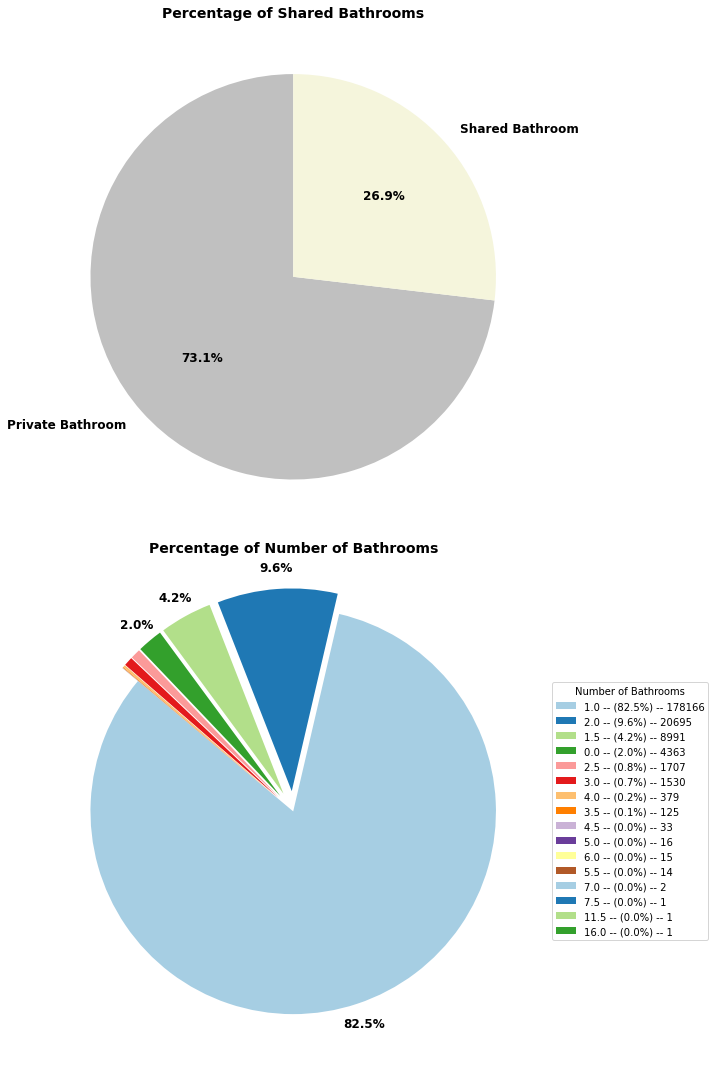

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(15, 15))

# Create a pie chart for Shared Bathrooms

shared_bathrooms_count = df['shared_bathroom'].value_counts()

axes[0].pie(shared_bathrooms_count, labels=['Private Bathroom', 'Shared Bathroom'],
            colors=['silver', 'beige'], autopct='%1.1f%%', startangle=90,
            textprops={'fontweight': 'bold', 'fontsize': 12})
axes[0].set_title('Percentage of Shared Bathrooms',
                  fontdict={'fontsize': 14, 'fontweight': 'bold'})


# Create a pie chart for Number of Bathrooms

bathrooms_count = df['bathrooms'].value_counts()

# Filter slices with percentages less than 10%
small_slices = bathrooms_count[bathrooms_count / bathrooms_count.sum() < 0.1]

# Explode slices with percentages less than 10%
explode = [0.1 if index in small_slices.index else 0 for index in bathrooms_count.index]
wedges, texts, autotexts = axes[1].pie(bathrooms_count, labels=None, autopct=lambda p: f'{p:.1f}%' if p > 1 else '', pctdistance=1.105,
                                  explode=explode, startangle=140, colors=plt.cm.Paired.colors, textprops={'fontsize': 12, 'fontweight': 'bold'})

# Add legend with corresponding percentages and counts
legend_labels = [f'{label} -- ({bathrooms_count[label] / bathrooms_count.sum():.1%}) -- {bathrooms_count[label]}' for label in bathrooms_count.index]
axes[1].legend(wedges, legend_labels, title='Number of Bathrooms', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

axes[1].set_title('Percentage of Number of Bathrooms', fontdict={'fontsize': 14, 'fontweight': 'bold'})

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [48]:
df['bathrooms'] = np.where(df['bathrooms'] > 3, 2, df['bathrooms'])

**Observations containing more than 3 bathrooms are replaced with 2.**

### Amenities Features: 
* `has_ac`
* `has_heating`
* `has_wifi`
* `has_essentials`
* `has_kitchen`
* `has_tv`
* `has_washer`
* `has_safety`
* `has_workspace`
* `children_pet_friendly`
* `has_gym`
* `has_pool`
* `has_fireplace`
* `has_views`
* `has_parking`

In [49]:
df['amenities'].unique()

array(['["Keypad", "Extra pillows and blankets", "TV", "Refrigerator", "Long term stays allowed", "Baking sheet", "Coffee maker", "Carbon monoxide alarm", "Oven", "Paid parking off premises", "Cleaning available during stay", "Ethernet connection", "Stove", "Wifi", "Free street parking", "Dishes and silverware", "Heating", "Dedicated workspace", "Luggage dropoff allowed", "Smoke alarm", "Hot water", "Bed linens", "Hangers", "Cooking basics", "Fire extinguisher", "Essentials", "Bathtub", "Kitchen", "Self check-in", "Iron", "Hair dryer", "Air conditioning"]',
       '["Kitchen", "Wifi", "Long term stays allowed", "Heating", "Air conditioning"]',
       '["Carbon monoxide alarm", "HDTV with Disney+, HBO Max, standard cable, Roku, Netflix", "Kitchen", "Wifi", "Outdoor furniture", "Long term stays allowed", "Heating", "Refrigerator", "Outdoor dining area", "Dryer", "Washer", "Smoke alarm", "Private patio or balcony", "Private backyard \\u2013 Fully fenced", "BBQ grill", "Hair dryer", "Air c

In [50]:
ac_keywords = ['AC', 'air conditioning'] 
df['has_ac'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in ac_keywords) else 0)

df['has_heating'] = df['amenities'].apply(lambda x: 1 if re.search(r'\bHeating\b', x, re.IGNORECASE) else 0)

wifi_keywords = ['wifi', 'ethernet']
df['has_wifi'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in wifi_keywords) else 0)

essentials_keywords = ['essentials', 'toilet paper', 'hand soap', 'body soap', 'towel', 'pillow', 'per guest', 'linens']
df['has_essentials'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in essentials_keywords) else 0)

df['has_kitchen'] = df['amenities'].apply(lambda x: 1 if re.search(r'\bkitchen\b', x, re.IGNORECASE) else 0)

tv_keywords = ['TV', 'cable']
df['has_tv'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in tv_keywords) else 0)

df['has_washer'] = df['amenities'].apply(lambda x: 1 if re.search(r'\bWasher\b', x, re.IGNORECASE) else 0)

safety_keywords = ['security alarm', 'smoke alarm', 'carbon monoxide alarm', 'fire extinguisher', 'first-aid kit']
df['has_safety'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in safety_keywords) else 0)

workspace_keywords = ['office', 'workspace', 'work', 'remote']
df['has_workspace'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in workspace_keywords) else 0)

children_pets_keywords = ['high chair', 'crib', 'baby safety gates', 'furniture covers', 'bowls for pet food and water', 'pet', 'pets', 'dog', 'cat']
df['children_pet_friendly'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in children_pets_keywords) else 0)

gym_keywords = ['gym', 'fitness equipment', 'exercise', 'weight', 'training']
df['has_gym'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in gym_keywords) else 0)

df['has_pool'] = df['amenities'].apply(lambda x: 1 if re.search(r'\bpool\b', x, re.IGNORECASE) else 0)

fireplace_keywords = ['fireplace', 'pit']
df['has_fireplace'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in fireplace_keywords) else 0)

views_keywords = ['city views', 'city skyline view', 'skyline', 'views', 'cityscape']
df['has_views'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in views_keywords) else 0)

parking_keywords = ['parking', 'garage', 'car']
df['has_parking'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in parking_keywords) else 0)

**The `amenities` feature contains a list of multiple amenities, which makes it difficult to derive insight. Regular expression operators are used to extract key words of popular amenities. If the key word(s) are in the list of amenities, a new column is created with the value 1 to indicate its presence and 0 otherwise.**

In [51]:
amenities_cols = ['has_ac', 'has_heating', 'has_wifi', 'has_essentials', 'has_kitchen', 'has_tv',
                  'has_washer', 'has_safety', 'has_workspace', 'children_pet_friendly', 'has_gym',
                  'has_pool', 'has_fireplace', 'has_views', 'has_parking']

for col in amenities_cols:
    print(f"'{col}':{(df[col] == 1).sum()},")

'has_ac':184724,
'has_heating':181560,
'has_wifi':202740,
'has_essentials':171035,
'has_kitchen':177982,
'has_tv':146757,
'has_washer':83485,
'has_safety':191091,
'has_workspace':115535,
'children_pet_friendly':64068,
'has_gym':36161,
'has_pool':6125,
'has_fireplace':12839,
'has_views':12442,
'has_parking':112524,


In [52]:
amenities_dict = {'AC':184724,
                  'Heating':181560,
                  'Wifi':202740,
                  'Essentials':171035,
                  'Kitchen':177982,
                  'TV':146757,
                  'Washer':83485,
                  'Safety':191091,
                  'Workspace':115535,
                  'Children/Pet Friendly':64068,
                  'Gym':36161,
                  'Pool':6125,
                  'Fireplace':12839,
                  'Views':12442,
                  'Parking':112524}

# Bar chart for Amenities
amenities = list(amenities_dict.keys())
values = list(amenities_dict.values())

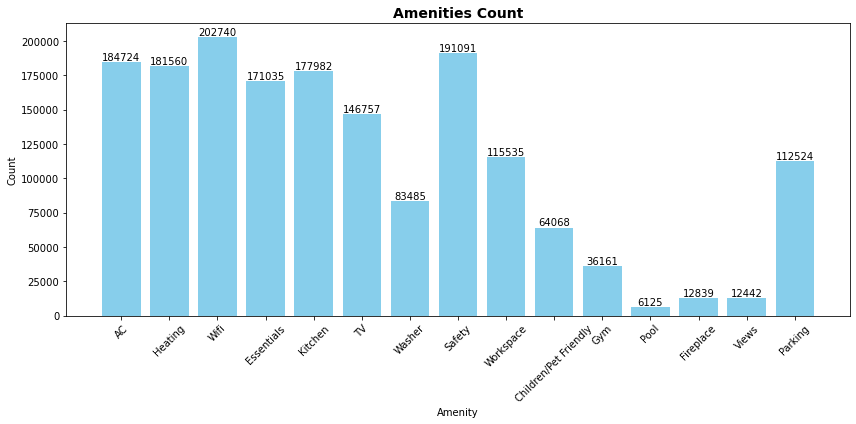

In [53]:
fig = plt.figure(figsize=(12,6))
bars = plt.bar(amenities, values, color='skyblue')
plt.title('Amenities Count', fontdict={'fontsize':14, 'fontweight':'bold'})
plt.xticks(rotation=45)
plt.xlabel('Amenity')
plt.ylabel('Count')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [54]:
df = df.drop(['amenities'], axis = 1)

**The original `amenities` column is dropped.**

## Geospatial Analysis

This section provides insight to the location of each Airbnb listing. The Airbnb dataset provides latitude and longitude coordiates that are utilized to create maps with highlighted features. In addition, a feature is extracted `nearest_transit_mi` using additional datasets from the MTA.

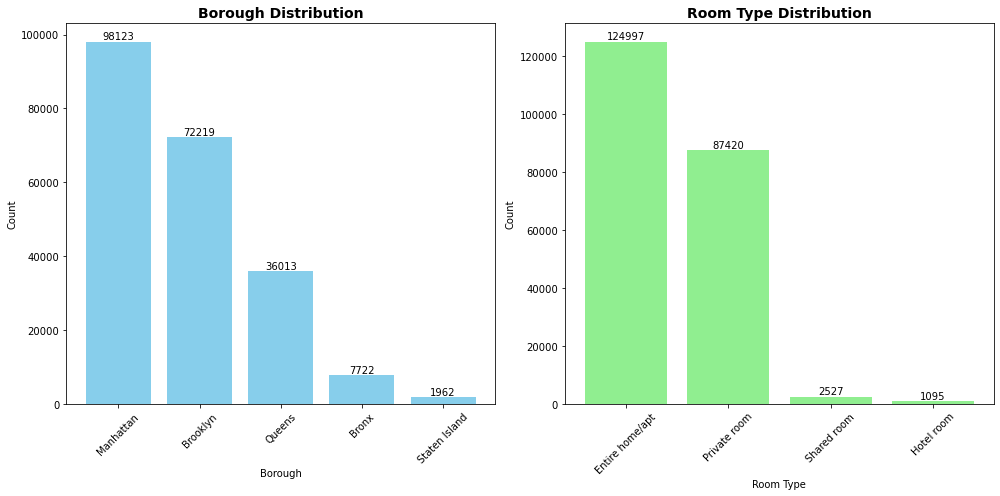

In [55]:
borough_counts = df['borough'].value_counts()
room_type_counts = df['room_type'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Bar chart for Boroughs
axes[0].bar(borough_counts.index, borough_counts, color='skyblue')
axes[0].set_title('Borough Distribution', fontdict={'fontsize':14, 'fontweight':'bold'})
axes[0].set_xlabel('Borough')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

for i, v in enumerate(borough_counts):
    axes[0].text(i, v + 0.2, str(v), ha='center', va='bottom')

# Bar chart for Property Types
axes[1].bar(room_type_counts.index, room_type_counts, color='lightgreen')
axes[1].set_title('Room Type Distribution', fontdict={'fontsize':14, 'fontweight':'bold'})
axes[1].set_xlabel('Room Type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

for i, v in enumerate(room_type_counts):
    axes[1].text(i, v + 0.2, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

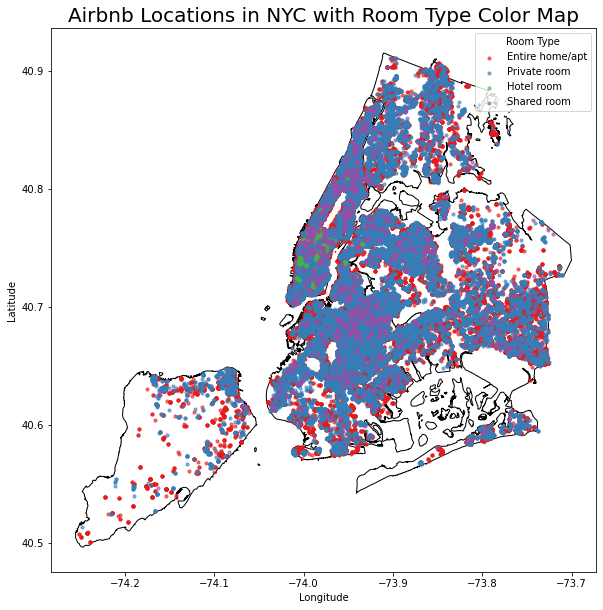

In [56]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf_airbnb = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load NYC boroughs shapefile from geodatasets
nybb = get_path('nybb')
boroughs = gpd.read_file(nybb)

# Plot boroughs
fig, ax = plt.subplots(figsize=(12, 10))
boroughs.to_crs("EPSG:4326").plot(ax=ax, color="white", edgecolor="black")

# Create Seaborn color palette for room types
room_type_palette = sns.color_palette("Set1", n_colors=len(gdf_airbnb['room_type'].unique()))

# Create scatter plot with different colors for each room type
for room_type, color in zip(gdf_airbnb['room_type'].unique(), room_type_palette):
    subset = gdf_airbnb[gdf_airbnb['room_type'] == room_type]
    subset.plot(ax=ax, markersize=10, color=color, alpha=0.6, label=room_type)

# Add legend
ax.legend(title='Room Type')

# Set plot title and labels
plt.title('Airbnb Locations in NYC with Room Type Color Map', fontsize=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

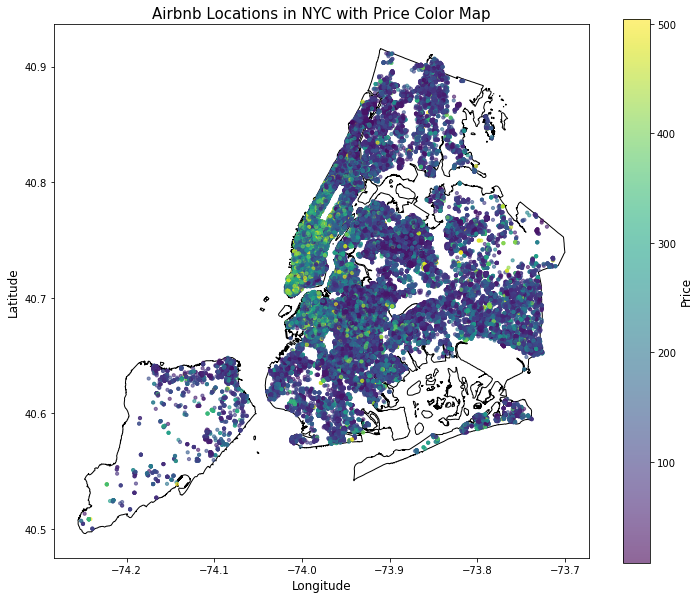

In [57]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf_airbnb = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load NYC boroughs shapefile from geodatasets
nybb = gpd.datasets.get_path('nybb')
boroughs = gpd.read_file(nybb)

# Plot boroughs
fig, ax = plt.subplots(figsize=(12, 10))
boroughs.to_crs("EPSG:4326").plot(ax=ax, color="white", edgecolor="black")

# Create Seaborn color palette for price
price_palette = sns.color_palette('viridis', as_cmap=True)

# Create scatter plot with different colors for each room type
scatter = ax.scatter(
    x=gdf_airbnb['longitude'],
    y=gdf_airbnb['latitude'],
    c=gdf_airbnb['price'],  # Color based on price
    cmap=price_palette,  # Use viridis color map
    s=10,
    alpha=0.6,
    label=gdf_airbnb['room_type']
)

# Add color bar
cbar = plt.colorbar(scatter, label='Price')
cbar.set_label('Price', fontsize=12)

# Set plot title and labels
plt.title('Airbnb Locations in NYC with Price Color Map', fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

plt.show()

### Feature Extraction of Location

**In this section, I attempt to create a new variable for distance to `nearest_transit_mi`.**

I load data from MTA's Data Feed that includes coordinates of buses and subways across all 5 boroughs. I use the `haversine_distances` function from `sklearn.metrics.pairwise` to create a distance matrix of all Airbnb listings and all transit stops. The minimum distance is extracted for each listing and placed in a new column `nearest_transit_mi`.

Unfortunately in the later section, it is shown that this feature is not well correlated to the price feature. Therefore it will not be used in the machine learning model predictions.

In [58]:
airbnb_df = df[['latitude', 'longitude']].copy()
airbnb_df = airbnb_df.drop_duplicates(subset=['latitude', 'longitude'])
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60134 entries, 0 to 38328
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   60134 non-null  float64
 1   longitude  60134 non-null  float64
dtypes: float64(2)
memory usage: 1.4 MB


In [59]:
# Load csv file of metro and bus station coordinates of NYC
transit_df = pd.read_csv('bus_metro.csv')

# Convert latitude and longitude to radians
airbnb_df['lat_rad'] = airbnb_df['latitude'].apply(radians)
airbnb_df['lon_rad'] = airbnb_df['longitude'].apply(radians)
transit_df['lat_rad'] = transit_df['stop_lat'].apply(radians)
transit_df['lon_rad'] = transit_df['stop_lon'].apply(radians)

earth_radius_mi = 3963.1906

# Calculate haversine distances
distances = haversine_distances(transit_df[['lat_rad', 'lon_rad']].values,
                                airbnb_df[['lat_rad', 'lon_rad']].values) * earth_radius_mi

# Extract minimum distance, Store it as a DataFrame, and add to airbnb_df
nearest_transit = distances.min(axis=0)
nearest_transit_df = pd.DataFrame(nearest_transit, columns=['nearest_transit'])
airbnb_df['nearest_transit_mi'] = nearest_transit_df['nearest_transit']
airbnb_df.columns

Index(['latitude', 'longitude', 'lat_rad', 'lon_rad', 'nearest_transit_mi'], dtype='object')

In [60]:
# Merge airbnb_df with the df using the common columns 'latitude' and 'longitude'
airbnb_df = airbnb_df.drop(columns=['lat_rad', 'lon_rad'])
airbnb_df.info()
df = pd.merge(df, airbnb_df, how='left', on=['latitude', 'longitude'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60134 entries, 0 to 38328
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            60134 non-null  float64
 1   longitude           60134 non-null  float64
 2   nearest_transit_mi  60134 non-null  float64
dtypes: float64(3)
memory usage: 1.8 MB


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216039 entries, 0 to 216038
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   host_acceptance_rate    216039 non-null  float64       
 1   host_is_superhost       216039 non-null  object        
 2   host_listings_count     216039 non-null  float64       
 3   host_identity_verified  216039 non-null  object        
 4   neighborhood            216039 non-null  object        
 5   borough                 216039 non-null  object        
 6   latitude                216039 non-null  float64       
 7   longitude               216039 non-null  float64       
 8   room_type               216039 non-null  object        
 9   accommodates            216039 non-null  int64         
 10  bedrooms                216039 non-null  float64       
 11  beds                    216039 non-null  float64       
 12  price                   216039

In [61]:
df.to_csv('airbnb.csv', index=False)  

## Feature Importance & Feature Selection

In this section, I first **label encode** and **one hot encode** categorical features. 

I then create a **Correlation Heatmap** of all the features to visually compare which features are more correlated with the `price` feature. I select features that have a correlation coefficient with the `price` feature of |±0.10|. I run a **second Correlation Heatmap** to have a bigger picture of which features were selected. Afterwards, I conduct a **p-value analysis** at the α = 0.05 level to confirm that the features selected show feature importance.

Lastly, I create **two OLS Regressions** with the selected features but with different outcome features: **`price` and `log_price`**. The purpose is to compare the R2 values of each regression to see **whether there is a benefit of applying the natural logarithmic function to the `price` feature.**

In [62]:
df.columns

Index(['host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_identity_verified', 'neighborhood', 'borough', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'review_scores_rating',
       'instant_bookable', 'date', 'shared_bathroom', 'bathrooms', 'has_ac',
       'has_heating', 'has_wifi', 'has_essentials', 'has_kitchen', 'has_tv',
       'has_washer', 'has_safety', 'has_workspace', 'children_pet_friendly',
       'has_gym', 'has_pool', 'has_fireplace', 'has_views', 'has_parking',
       'nearest_transit_mi'],
      dtype='object')

### Label Encoding
As shown four cells below, all of the label encoded features and one-hot encoded features were transformed properly.

In [63]:
le = LabelEncoder()

object_cols = ['host_is_superhost', 'host_identity_verified', 'instant_bookable']

print('Label Encoder Transformation')
for col in object_cols :
    df[col] = le.fit_transform(df[col])
    print(col,':',df[col].unique(),'=',le.inverse_transform(df[col].unique())) 

Label Encoder Transformation
host_is_superhost : [0 1] = ['f' 't']
host_identity_verified : [1 0] = ['t' 'f']
instant_bookable : [0 1] = ['f' 't']


In [64]:
df_boroughs = pd.get_dummies(df['borough'], prefix='', prefix_sep='')
df_room_type = pd.get_dummies(df['room_type'], prefix='', prefix_sep='')
df = pd.concat([df, df_boroughs, df_room_type], axis=1, join='inner')

In [65]:
df = df.drop(columns=['neighborhood', 'borough', 'room_type'])

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216039 entries, 0 to 216038
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   host_acceptance_rate    216039 non-null  float64       
 1   host_is_superhost       216039 non-null  int64         
 2   host_listings_count     216039 non-null  float64       
 3   host_identity_verified  216039 non-null  int64         
 4   latitude                216039 non-null  float64       
 5   longitude               216039 non-null  float64       
 6   accommodates            216039 non-null  int64         
 7   bedrooms                216039 non-null  float64       
 8   beds                    216039 non-null  float64       
 9   price                   216039 non-null  float64       
 10  minimum_nights          216039 non-null  int64         
 11  maximum_nights          216039 non-null  int64         
 12  review_scores_rating    216039

### Correlation Heatmaps

In [67]:
# Shift 'price' feature to the end of the DataFrame for correlation analysis
col = df.pop('price')
df.insert(40, col.name, col)

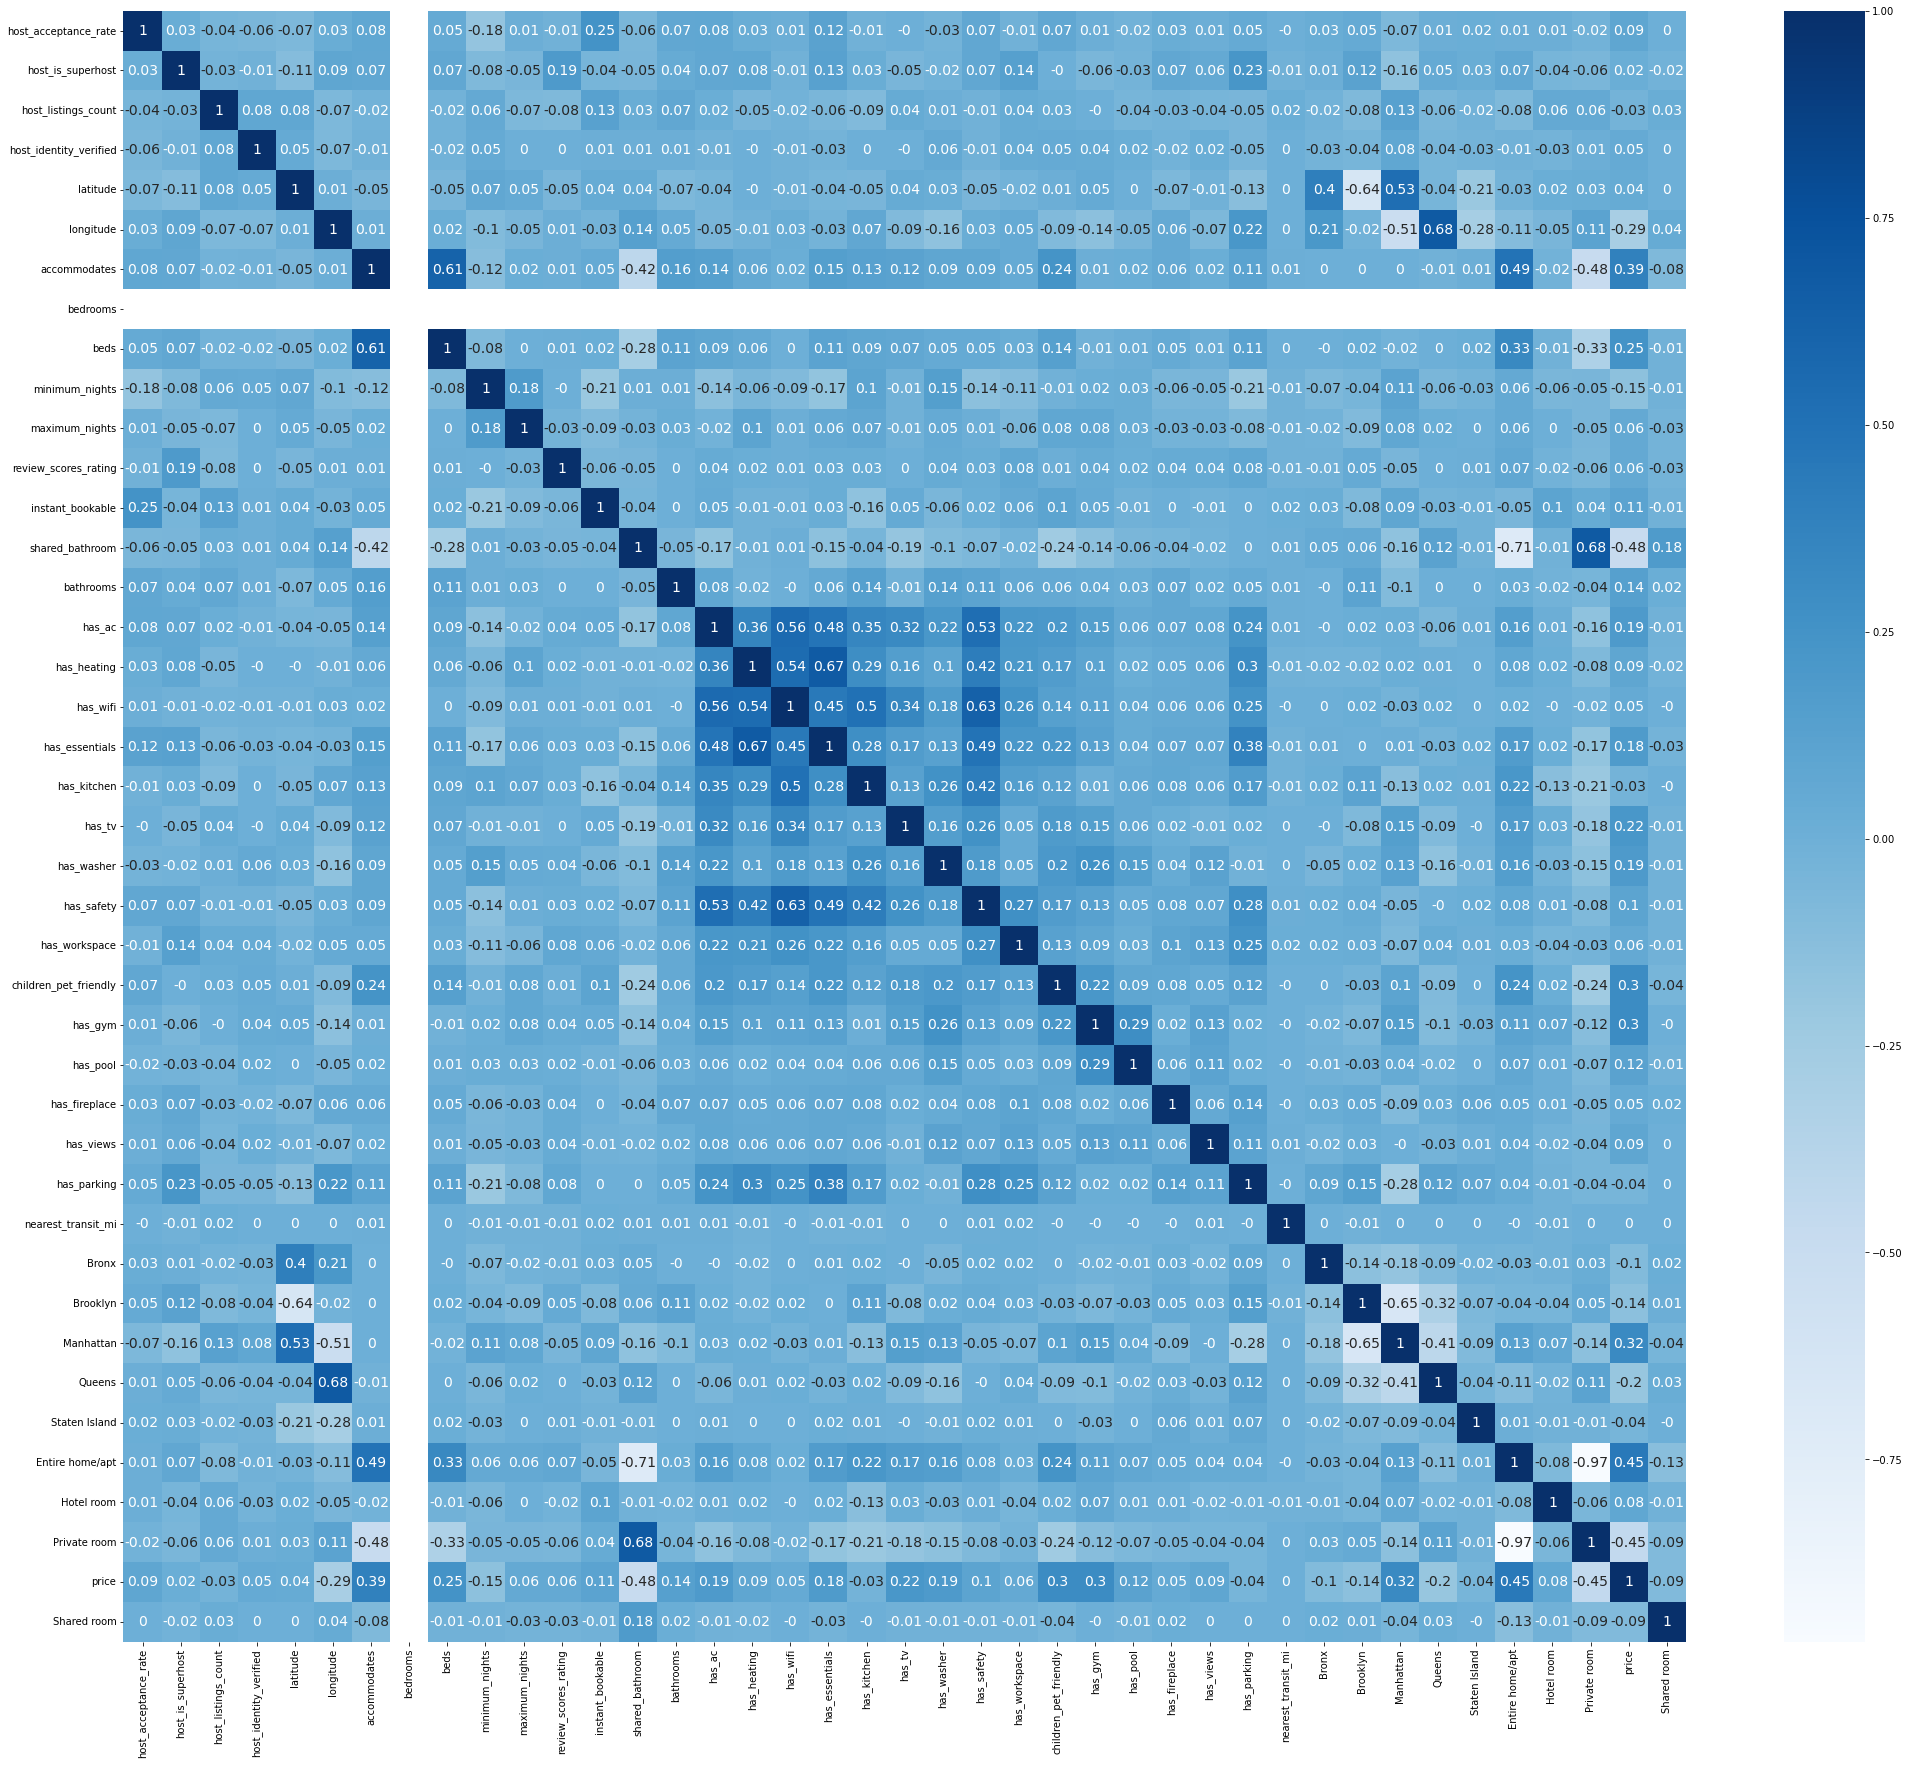

In [68]:
correlation_matrix = df.corr().round(2)
plt.figure(figsize=(35, 30))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, annot_kws={'fontsize': 14})
plt.show()

In [69]:
correlated_features=[]
for col in correlation_matrix.columns:
    correlation = correlation_matrix.loc[col, 'price']
    if abs(correlation) >= 0.1:
        correlated_features.append(col)

In [70]:
correlated_features

['longitude',
 'accommodates',
 'beds',
 'minimum_nights',
 'instant_bookable',
 'shared_bathroom',
 'bathrooms',
 'has_ac',
 'has_essentials',
 'has_tv',
 'has_washer',
 'has_safety',
 'children_pet_friendly',
 'has_gym',
 'has_pool',
 'Bronx',
 'Brooklyn',
 'Manhattan',
 'Queens',
 'Entire home/apt',
 'Private room',
 'price']

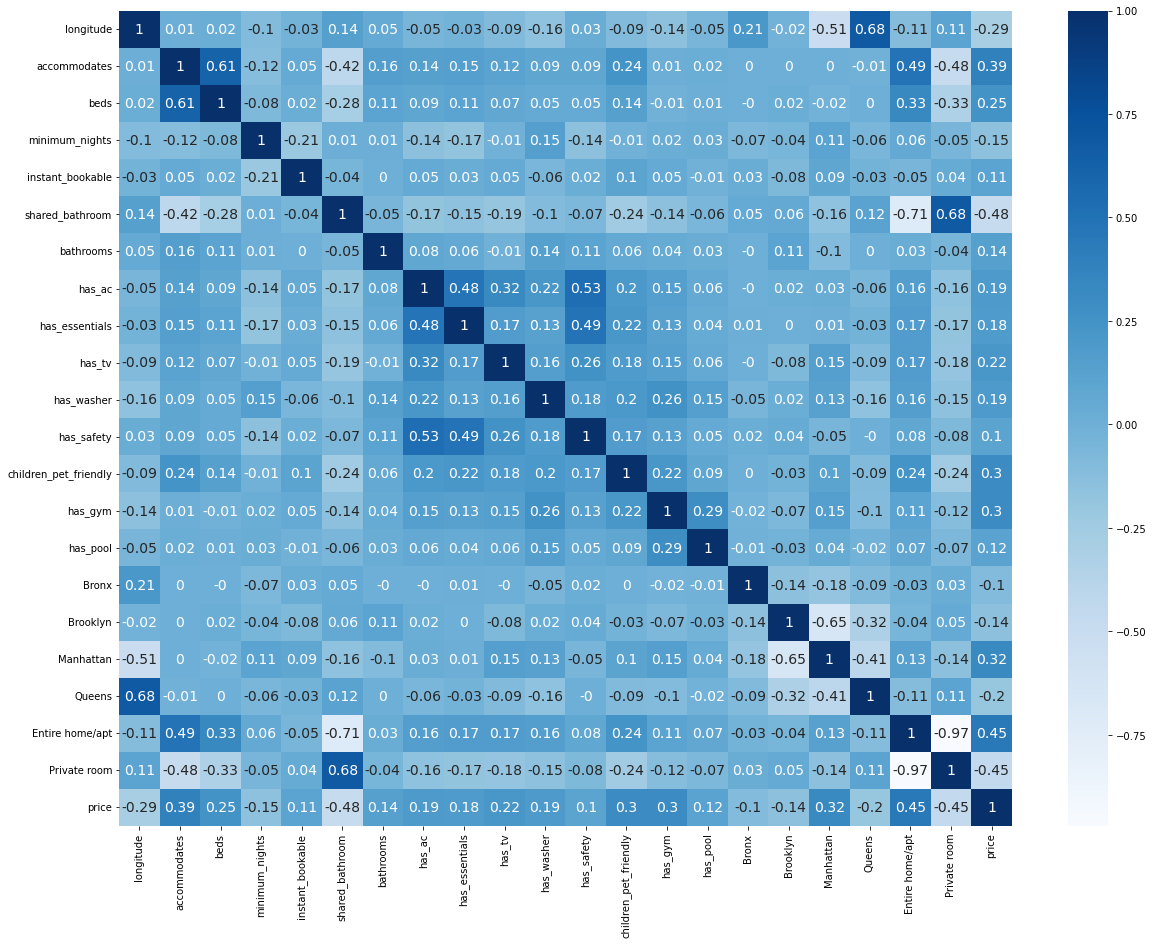

In [71]:
correlation_matrix = df[correlated_features].corr().round(2)
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, annot_kws={'fontsize': 14})
plt.show()

### P-value Analysis & Natural Logarithmic Transformation

The code in cell [72] contains the OLS Regression Results of the selected features and the `price` feature.

The code in cell [74] contains the OLS Regression Results of the selected features and the `log_price` feature.

In [72]:
X = df[['longitude', 'accommodates', 'beds', 'minimum_nights', 'instant_bookable', 'shared_bathroom', 
        'bathrooms','has_ac', 'has_essentials', 'has_tv', 'has_washer', 'has_safety', 'children_pet_friendly',
        'has_gym', 'has_pool', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Entire home/apt', 'Private room']]

y = df['price']

# Add a constant term to the features matrix
X = sm.add_constant(X)

# Fit the multivariate linear regression model
price_model = sm.OLS(y, X).fit()

In [73]:
df['log_price'] = np.log(df['price'])

In [74]:
X = df[['longitude', 'accommodates', 'beds', 'minimum_nights', 'instant_bookable', 'shared_bathroom',
        'bathrooms', 'has_ac', 'has_essentials', 'has_tv', 'has_washer', 'has_safety', 'children_pet_friendly',
        'has_gym', 'has_pool', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Entire home/apt', 'Private room']]

y = df['log_price']

# Add a constant term to the features matrix
X = sm.add_constant(X)

# Fit the multivariate linear regression model
log_price_model = sm.OLS(y, X).fit()
print(log_price_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                 1.460e+04
Date:                Tue, 07 May 2024   Prob (F-statistic):               0.00
Time:                        23:49:51   Log-Likelihood:            -1.2482e+05
No. Observations:              216039   AIC:                         2.497e+05
Df Residuals:                  216017   BIC:                         2.499e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -175.38

In [75]:
print('R2 of Price OLS Model:', price_model.rsquared.round(4), 
      '\nR2 of Log Price OLS Model:', log_price_model.rsquared.round(4))

R2 of Price OLS Model: 0.4747 
R2 of Log Price OLS Model: 0.5867


**The `log_price` OLS Regression Model performed 23.59% better than the `price` OLS Regression Model. This confirms that applying the natural logarithmic transformation to the `price` feature improves the performance of price prediction models.**

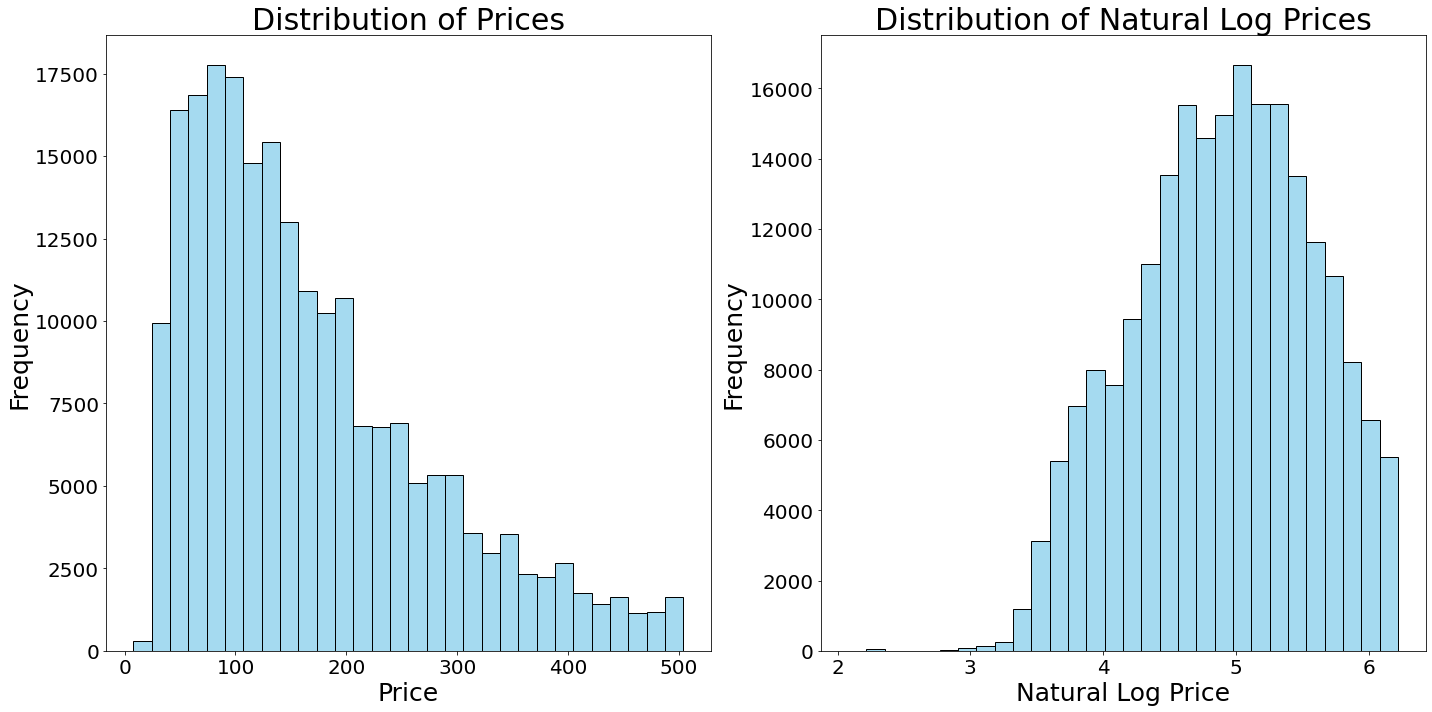

In [76]:
# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Distribution of Prices
sns.histplot(df['price'], ax=axes[0], color='skyblue', bins=30)
axes[0].set_title('Distribution of Prices', fontsize=30)
axes[0].set_xlabel('Price', fontsize=25)
axes[0].set_ylabel('Frequency', fontsize=25)
axes[0].tick_params(axis='both', which='major', labelsize=20)

# Distribution of Natural Log Prices
sns.histplot(df['log_price'], ax=axes[1], color='skyblue', bins=30)
axes[1].set_title('Distribution of Natural Log Prices', fontsize=30)
axes[1].set_xlabel('Natural Log Price', fontsize=25)
axes[1].set_ylabel('Frequency', fontsize=25)
axes[1].tick_params(axis='both', which='major', labelsize=20)


plt.tight_layout()
plt.show()

**The graphs above show that the distribution of `price` is skewed to the right while the distribution of `log_price` is normal. This also confirms that applying the natural logarithmic transformation to the `price` feature reduces the variance and improves the R2 value.**

## Model Implementation

**The machine learning models implemented are as follows: Linear Regression, Support Vector Regressor, Decision Tree Regressor, Random Forest Regressor, and XGBoost Regressor.**

Train and test evaluation metrics of all models are calculated for the basic models. The code for the Support Vector Regressor was commented out in the final Run because it is computationally expensive (3 hours to run), but the metrics are provided in the proceeding cell. For each model, the metrics are printed for each regressor. 

Later on, hyperparameter tuning will be performed on the Decision Tree Regressor, Random Forest Regressor, and XGBoost Regressor. The best parameters of the Decision Tree Regressor were implemented in the Random Forest Regressor.

In [77]:
df.columns

Index(['host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_identity_verified', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'instant_bookable', 'date', 'shared_bathroom',
       'bathrooms', 'has_ac', 'has_heating', 'has_wifi', 'has_essentials',
       'has_kitchen', 'has_tv', 'has_washer', 'has_safety', 'has_workspace',
       'children_pet_friendly', 'has_gym', 'has_pool', 'has_fireplace',
       'has_views', 'has_parking', 'nearest_transit_mi', 'Bronx', 'Brooklyn',
       'Manhattan', 'Queens', 'Staten Island', 'Entire home/apt', 'Hotel room',
       'Private room', 'price', 'Shared room', 'log_price'],
      dtype='object')

In [78]:
features = ['longitude', 'accommodates', 'beds', 'minimum_nights', 'instant_bookable', 'shared_bathroom',
            'bathrooms', 'has_ac', 'has_essentials', 'has_tv', 'has_washer', 'has_safety',
            'children_pet_friendly', 'has_gym', 'has_pool', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',
            'Staten Island', 'Entire home/apt', 'Private room', 'Hotel room']

In [79]:
X = df[features]
y = df.log_price

In [80]:
X.describe()

,longitude,accommodates,beds,minimum_nights,instant_bookable,shared_bathroom,bathrooms,has_ac,has_essentials,has_tv,...,has_gym,has_pool,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Hotel room
count,216039.000000,216039.000000,216039.000000,216039.000000,216039.000000,216039.000000,216039.000000,216039.000000,216039.000000,216039.000000,...,216039.000000,216039.000000,216039.000000,216039.000000,216039.000000,216039.000000,216039.000000,216039.000000,216039.000000,216039.000000
mean,-73.944152,2.690852,1.407079,17.149223,0.254542,0.268632,1.125139,0.855049,0.791686,0.679308,...,0.167382,0.028351,0.035744,0.334287,0.454191,0.166697,0.009082,0.578585,0.404649,0.005069
std,0.056846,1.412000,0.661654,14.099404,0.435604,0.443249,0.399446,0.352052,0.406104,0.466744,...,0.373317,0.165975,0.185650,0.471742,0.497898,0.372706,0.094864,0.493787,0.490825,0.071013
min,-74.251907,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-73.983640,2.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-73.953500,2.000000,1.000000,30.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,-73.923250,4.000000,2.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,-73.710870,7.000000,3.000000,70.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
X.shape

(216039, 23)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
# Instantiate the Linear Regression model
reg_model = LinearRegression()

# Fit the model
reg_model.fit(X_train, y_train)

# Predict the model
y_pred_train_reg = reg_model.predict(X_train)
y_pred_test_reg = reg_model.predict(X_test)

# Evaluation Metrics for Linear Regression 
r2_train_reg = r2_score(y_train, y_pred_train_reg).round(4)
mse_train_reg = mse(y_train, y_pred_train_reg).round(4)
rmse_train_reg = (mse_train_reg**0.5).round(4)

r2_test_reg = r2_score(y_test, y_pred_test_reg).round(4)
mse_test_reg = mse(y_test, y_pred_test_reg).round(4)
rmse_test_reg = (mse_test_reg**0.5).round(4)

In [84]:
reg_metrics = {'R2':[r2_train_reg, r2_test_reg],
               'MSE':[mse_train_reg, rmse_test_reg],
               'RMSE':[rmse_train_reg, rmse_test_reg]}

reg_metrics_df = pd.DataFrame(reg_metrics)
reg_metrics_df = reg_metrics_df.rename(index={0:'Linear Regression Train Metrics',
                                              1:'Linear Regression Test Metrics'})

print('Linear Regression Metrics:\n')
print(reg_metrics_df)

Linear Regression Metrics:

                                     R2     MSE    RMSE
Linear Regression Train Metrics  0.5886  0.1853  0.4305
Linear Regression Test Metrics   0.5939  0.4265  0.4265


In [85]:
# # Instantiate the Support Vector Regressor model
# svr_model = Pipeline([
#     ('scaler', StandardScaler()),
#     ('svr', SVR(kernel='rbf', max_iter=200000))])

# # Fit the model with train data
# svr_model.fit(X_train, y_train)

# # Predict the model with train and test data
# y_pred_train_svr = svr_model.predict(X_train)
# y_pred_test_svr = svr_model.predict(X_test)

# # Evaluation Metrics for Support Vector Regressor 
# r2_train_svr = r2_score(y_train, X_train).round(4)
# mse_train_svr = mse(y_train, X_train).round(4)
# rmse_train_svr = (mse_train_svr**0.5).round(4)

# r2_test_svr = r2_score(y_test, X_test).round(4)
# mse_test_svr = mse(y_test, X_test).round(4)
# rmse_test_svr = (mse_test_svr**0.5).round(4)

In [86]:
r2_train_svr = 0.7115
mse_train_svr = 0.1300
rmse_train_svr = 0.3606

r2_test_svr = 0.7027
mse_test_svr = 0.1332
rmse_test_svr = 0.3650

svr_metrics = {'R2':[r2_train_svr, r2_test_svr],
               'MSE':[mse_train_svr, mse_test_svr],
               'RMSE':[rmse_train_svr, rmse_test_svr]}

svr_metrics_df = pd.DataFrame(svr_metrics)
svr_metrics_df = svr_metrics_df.rename(index={0:'Support Vector Train Metrics',
                                              1:'Support Vector Test Metrics'})

print('Support Vector Regressor Metrics:\n')
print(svr_metrics_df)

Support Vector Regressor Metrics:

                                  R2     MSE    RMSE
Support Vector Train Metrics  0.7115  0.1300  0.3606
Support Vector Test Metrics   0.7027  0.1332  0.3650


In [87]:
# Instantiate the Decision Tree Regressor model
decision_tree = DecisionTreeRegressor()  
  
# Fit the model with train data
decision_tree.fit(X_train, y_train)

# Predict the model with train and test data
y_pred_train_og_dt = decision_tree.predict(X_train)
y_pred_test_og_dt = decision_tree.predict(X_test)

# Evaluation Metrics for Decision Tree Regressor model
r2_train_og_dt = r2_score(y_train, y_pred_train_og_dt).round(4)
mse_train_og_dt = mse(y_train, y_pred_train_og_dt).round(4)
rmse_train_og_dt = (mse_train_og_dt**0.5).round(4)

r2_test_og_dt = r2_score(y_test, y_pred_test_og_dt).round(4)
mse_test_og_dt = mse(y_test, y_pred_test_og_dt).round(4)
rmse_test_og_dt = (mse_test_og_dt**0.5).round(4)

In [88]:
og_dt_metrics = {'R2':[r2_train_og_dt, r2_test_og_dt],
                 'MSE':[mse_train_og_dt, mse_test_og_dt],
                 'RMSE':[rmse_train_og_dt, rmse_test_og_dt]}

og_dt_metrics_df = pd.DataFrame(og_dt_metrics)
og_dt_metrics_df = og_dt_metrics_df.rename(index={0:'Decision Tree Train Metrics',
                                                  1:'Decision Tree Test Metrics'})

print('Decision Tree Regressor Metrics:\n')
print(og_dt_metrics_df)

Decision Tree Regressor Metrics:

                                 R2     MSE    RMSE
Decision Tree Train Metrics  0.9514  0.0219  0.1480
Decision Tree Test Metrics   0.7341  0.1191  0.3451


In [89]:
# Instantiate the Random Forest Regressor model
random_forest = RandomForestRegressor()

# Fit the model with train data
random_forest.fit(X_train, y_train)

# Predict the model with train and test data
y_pred_train_og_rf = random_forest.predict(X_train)
y_pred_test_og_rf = random_forest.predict(X_test)

# Evaluation Metrics for Random Forest Regressor model
r2_train_og_rf = r2_score(y_train, y_pred_train_og_rf).round(4)
mse_train_og_rf = mse(y_train, y_pred_train_og_rf).round(4)
rmse_train_og_rf = (mse_train_og_rf**0.5).round(4)

r2_test_og_rf = r2_score(y_test, y_pred_test_og_rf).round(4)
mse_test_og_rf = mse(y_test, y_pred_test_og_rf).round(4)
rmse_test_og_rf = (mse_test_og_rf**0.5).round(4)

In [90]:
og_rf_metrics = {'R2':[r2_train_og_rf, r2_test_og_rf],
                 'MSE':[mse_train_og_rf, mse_test_og_rf],
                 'RMSE':[rmse_train_og_rf, rmse_test_og_rf]}

og_rf_metrics_df = pd.DataFrame(og_rf_metrics)
og_rf_metrics_df = og_rf_metrics_df.rename(index={0:'Random Forest Train Metrics',
                                                  1:'Random Forest Test Metrics'})

print('Random Forest Regressor Metrics:\n')
print(og_rf_metrics_df)

Random Forest Regressor Metrics:

                                 R2     MSE    RMSE
Random Forest Train Metrics  0.9351  0.0292  0.1709
Random Forest Test Metrics   0.8047  0.0875  0.2958


In [91]:
# Instantiate the XGBoost Regressor model
xgboost = XGBRegressor()

# Fit the model with train data
xgboost.fit(X_train, y_train) 

# Predict the model with train and test data
y_pred_train_og_xgb = xgboost.predict(X_train) 
y_pred_test_og_xgb = xgboost.predict(X_test)

# Evaluation Metrics for XGBoost Regressor model
r2_train_og_xgb = r2_score(y_train, y_pred_train_og_xgb).round(4)
mse_train_og_xgb = mse(y_train, y_pred_train_og_xgb).round(4)
rmse_train_og_xgb = (mse_train_og_xgb**0.5).round(4)

r2_test_og_xgb = r2_score(y_test, y_pred_test_og_xgb).round(4)
mse_test_og_xgb = mse(y_test, y_pred_test_og_xgb).round(4)
rmse_test_og_xgb = (mse_test_og_xgb**0.5).round(4)

In [92]:
og_xgb_metrics = {'R2':[r2_train_og_xgb, r2_test_og_xgb],
                  'MSE':[mse_train_og_xgb, mse_test_og_xgb],
                  'RMSE':[rmse_train_og_xgb, rmse_test_og_xgb]}
                 
og_xgb_metrics_df = pd.DataFrame(og_xgb_metrics)
og_xgb_metrics_df = og_xgb_metrics_df.rename(index={0:'XGBoost Train Metrics',
                                                    1:'XGBoost Test Metrics'})

print('XGBoost Regressor Metrics:\n')
print(og_xgb_metrics_df)

XGBoost Regressor Metrics:

                           R2     MSE    RMSE
XGBoost Train Metrics  0.7382  0.1179  0.3434
XGBoost Test Metrics   0.7243  0.1235  0.3514


## Hyperparameter Tuning 
**Hyperparameter tuning will be applied on the Decision Tree Regressor, Random Forest Regressor, and XGBoost Regressor.**

A GridSearch was performed on the Decision Tree Regressor with parameters 'max_depth', 'max_leaf_nodes', and 'min_samples_leaf'. The best parameters of the Decision Tree Regressor were implemented in the Decision Tree Regressor and Random Forest Regressor.

A GridSearch was performed and applied on the XGBoost Regressor with parameters 'eta', 'subsample', and 'colsample_bytree'.

In [93]:
# Define the hyperparameter grid for Decision Tree Regressor
decision_tree_param_grid = {'max_depth': [20, 25, 30], 
                            'max_leaf_nodes': [2500, 3750, 5000], 
                            'min_samples_leaf': [2, 5, 7]}

# Instantiate GridSearchCV for Decision Tree Regressor
decision_tree_grid_search = GridSearchCV(decision_tree, decision_tree_param_grid)

# Fit GridSearchCV to the data
decision_tree_grid_search.fit(X_train, y_train)

print("Best hyperparameters for Decision Tree Regressor: ", decision_tree_grid_search.best_params_)

Best hyperparameters for Decision Tree Regressor:  {'max_depth': 30, 'max_leaf_nodes': 5000, 'min_samples_leaf': 5}


In [94]:
# Instantiate Tuned Decision Tree Regressor
decision_tree_model = DecisionTreeRegressor(max_depth=30, max_leaf_nodes=5000, min_samples_leaf=5)  
  
# Fit the model with train data
decision_tree_model.fit(X_train, y_train)

# Predict the model with train and test data
y_pred_train_dt = decision_tree_model.predict(X_train)
y_pred_test_dt = decision_tree_model.predict(X_test)

# Evaluation Metrics for Tuned Decision Tree Regressor model
r2_train_dt = r2_score(y_train, y_pred_train_dt).round(4)
mse_train_dt = mse(y_train, y_pred_train_dt).round(4)
rmse_train_dt = (mse_train_dt**0.5).round(4)

r2_test_dt = r2_score(y_test, y_pred_test_dt).round(4)
mse_test_dt = mse(y_test, y_pred_test_dt).round(4)
rmse_test_dt = (mse_test_dt**0.5).round(4)

In [95]:
dt_metrics = {'R2':[r2_train_dt, r2_test_dt],
              'MSE':[mse_train_dt, mse_test_dt],
              'RMSE':[rmse_train_dt, rmse_test_dt]}

dt_metrics_df = pd.DataFrame(dt_metrics)
dt_metrics_df = dt_metrics_df.rename(index={0:'Decision Tree (Tuned) Train Metrics',
                                            1:'Decision Tree (Tuned) Test Metrics'})

print('Tuned Decision Tree Regressor Metrics:\n')
print(dt_metrics_df)

Tuned Decision Tree Regressor Metrics:

                                         R2     MSE    RMSE
Decision Tree (Tuned) Train Metrics  0.7951  0.0923  0.3038
Decision Tree (Tuned) Test Metrics   0.7373  0.1177  0.3431


In [96]:
# Instantiate the Tuned Random Forest Regressor model
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=30, max_leaf_nodes=5000,
                                            min_samples_leaf=5, random_state=42)

# Fit the model with train data
random_forest_model.fit(X_train, y_train)

# Predict the model with train and test data
y_pred_train_rf = random_forest_model.predict(X_train)
y_pred_test_rf = random_forest_model.predict(X_test)

# Evaluation Metrics for Tuned Random Forest Regressor model
r2_train_rf = r2_score(y_train, y_pred_train_rf).round(4)
mse_train_rf = mse(y_train, y_pred_train_rf).round(4)
rmse_train_rf = (mse_train_rf**0.5).round(4)

r2_test_rf = r2_score(y_test, y_pred_test_rf).round(4)
mse_test_rf = mse(y_test, y_pred_test_rf).round(4)
rmse_test_rf = (mse_test_rf**0.5).round(4)

In [97]:
rf_metrics = {'R2':[r2_train_rf, r2_test_rf],
              'MSE':[mse_train_rf, mse_test_rf],
              'RMSE':[rmse_train_rf, rmse_test_rf]}

rf_metrics_df = pd.DataFrame(rf_metrics)
rf_metrics_df = rf_metrics_df.rename(index={0:'Random Forest (Tuned) Train Metrics',
                                            1:'Random Forest (Tuned) Test Metrics'})

print('Tuned Random Forest Regressor Metrics:\n')
print(rf_metrics_df)

Tuned Random Forest Regressor Metrics:

                                         R2     MSE    RMSE
Random Forest (Tuned) Train Metrics  0.8216  0.0803  0.2834
Random Forest (Tuned) Test Metrics   0.7736  0.1014  0.3184


In [98]:
# Define the hyperparameter grid for XGBoost Regressor
xgboost_param_grid = {'eta': [0.05, 0.075, 0.1],
                      'subsample': [0.625, 0.75, 0.875],
                      'colsample_bytree': [0.625, 0.75, 0.875]}

# Instantiate GridSearchCV for XGBoost Regressor
xgboost_grid_search = GridSearchCV(xgboost, xgboost_param_grid)

# Fit GridSearchCV to the data
xgboost_grid_search.fit(X_train, y_train)

print("Best hyperparameters for XGBoost Regressor: ", xgboost_grid_search.best_params_)

Best hyperparameters for XGBoost Regressor:  {'colsample_bytree': 0.875, 'eta': 0.05, 'subsample': 0.875}


In [99]:
# Instantiate the XGBoost Regressor model
xgboost_model = XGBRegressor(n_estimators=100, max_depth=20, eta=0.05, subsample=0.875, colsample_bytree=0.875)
  
# Fit the model with train data
xgboost_model.fit(X_train, y_train) 

# Predict the model with train and test data
y_pred_train_xgb = xgboost_model.predict(X_train) 
y_pred_test_xgb = xgboost_model.predict(X_test)

# Evaluation Metrics for XGBoost Regressor model
r2_train_xgb = r2_score(y_train, y_pred_train_xgb).round(4)
mse_train_xgb = mse(y_train, y_pred_train_xgb).round(4)
rmse_train_xgb = (mse_train_xgb**0.5).round(4)

r2_test_xgb = r2_score(y_test, y_pred_test_xgb).round(4)
mse_test_xgb = mse(y_test, y_pred_test_xgb).round(4)
rmse_test_xgb = (mse_test_xgb**0.5).round(4)

In [100]:
xgb_metrics = {'R2':[r2_train_xgb, r2_test_xgb],
               'MSE':[mse_train_xgb, mse_test_xgb],
               'RMSE':[rmse_train_xgb, rmse_test_xgb]}
                 
xgb_metrics_df = pd.DataFrame(xgb_metrics)
xgb_metrics_df = xgb_metrics_df.rename(index={0:'XGBoost (Tuned) Train Metrics',
                                              1:'XGBoost (Tuned) Test Metrics'})

print('Tuned XGBoost Regressor Metrics:\n')
print(xgb_metrics_df)

Tuned XGBoost Regressor Metrics:

                                   R2     MSE    RMSE
XGBoost (Tuned) Train Metrics  0.8875  0.0507  0.2252
XGBoost (Tuned) Test Metrics   0.8036  0.0880  0.2966


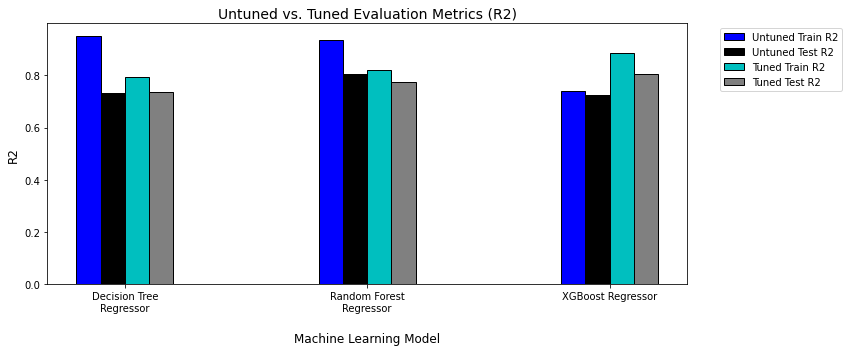

In [101]:
untuned_train_metrics = [r2_train_og_dt, r2_train_og_rf, r2_train_og_xgb]
untuned_test_metrics = [r2_test_og_dt, r2_test_og_rf, r2_test_og_xgb]
tuned_train_metrics = [r2_train_dt, r2_train_rf, r2_train_xgb]
tuned_test_metrics = [r2_test_dt, r2_test_rf, r2_test_xgb]

# Calculate the positions for each group of bars
x = np.arange(len(untuned_train_metrics))

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(x - 0.15, untuned_train_metrics, width=0.1, color='b', edgecolor='black', label='Untuned Train R2')
ax.bar(x - 0.05, untuned_test_metrics, width=0.1, color='k', edgecolor='black', label='Untuned Test R2')
ax.bar(x + 0.05, tuned_train_metrics, width=0.1, color='c', edgecolor='black', label='Tuned Train R2')
ax.bar(x + 0.15, tuned_test_metrics, width=0.1, color='grey', edgecolor='black', label='Tuned Test R2')

# Set title, labels, and ticks
plt.title('Untuned vs. Tuned Evaluation Metrics (R2)', fontsize=14)
plt.xlabel('\nMachine Learning Model', fontsize=12)
plt.ylabel('R2', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(['Decision Tree\nRegressor', 'Random Forest\nRegressor', 'XGBoost Regressor'])
ax.legend(loc='best', bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

plt.tight_layout()
plt.show()

In [102]:
tuned_dt_metrics_df = pd.concat([og_dt_metrics_df, dt_metrics_df])
tuned_rf_metrics_df = pd.concat([og_rf_metrics_df, rf_metrics_df])
tuned_xgb_metrics_df = pd.concat([og_xgb_metrics_df, xgb_metrics_df])
print(tuned_dt_metrics_df)
print(tuned_rf_metrics_df)
print(tuned_xgb_metrics_df)

                                         R2     MSE    RMSE
Decision Tree Train Metrics          0.9514  0.0219  0.1480
Decision Tree Test Metrics           0.7341  0.1191  0.3451
Decision Tree (Tuned) Train Metrics  0.7951  0.0923  0.3038
Decision Tree (Tuned) Test Metrics   0.7373  0.1177  0.3431
                                         R2     MSE    RMSE
Random Forest Train Metrics          0.9351  0.0292  0.1709
Random Forest Test Metrics           0.8047  0.0875  0.2958
Random Forest (Tuned) Train Metrics  0.8216  0.0803  0.2834
Random Forest (Tuned) Test Metrics   0.7736  0.1014  0.3184
                                   R2     MSE    RMSE
XGBoost Train Metrics          0.7382  0.1179  0.3434
XGBoost Test Metrics           0.7243  0.1235  0.3514
XGBoost (Tuned) Train Metrics  0.8875  0.0507  0.2252
XGBoost (Tuned) Test Metrics   0.8036  0.0880  0.2966


**Hyperparameter tuning worked provided benefits across all three Regressors.**

For the Decision Regressor, the tuned test R2 only increased 0.28% compared to the untuned test R2. However, the tuned train R2 decreased 15.63%. This shows that applying hyperparameter tuning worked well on providing a more robust model by being able to generalize better on unseen data.

For the Random Forest Regressor, the tuned test R2 decreased 3.12% compared to the untuned test R2, but the tuned train R2 decreased 11.35%. Although the test R2 decreased, the trade-off is that the model generalizes better with the hyperparameters. In addition, this model still performs better than the Decision Tree Regressor.

For the XGBoost Regressor, the tuned train and test R2 increased by 14.93% and 7.93% respectively compared to the untuned train and test R2. Although the test R2 increased significantly after tuning, the train R2 increased almost 2x as much as the test R2. This shows that hyperparameter tuning for the XGBoost Regressor exhibits some degree of overfitting, so it doesn't generalize unseen data as well as the Random Forest Regressor. However, the tuned test R2 of 0.8036 makes the tuned XGBoost Regressor the most accurate predictor.

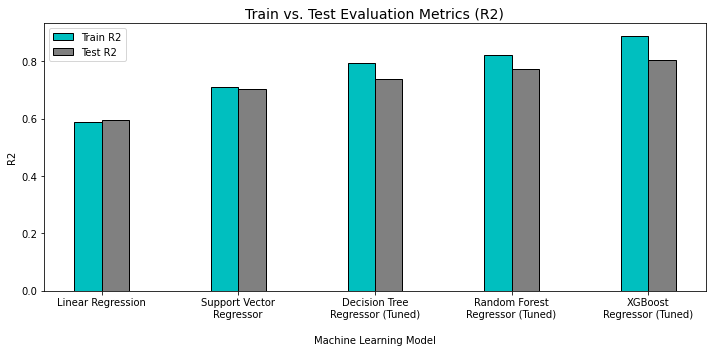

In [103]:
fig = plt.subplots(figsize =(10, 5)) 

# Define the variables to store the data 
train_metrics = [r2_train_reg, r2_train_svr, r2_train_dt, r2_train_rf, r2_train_xgb] 
test_metrics = [r2_test_reg, r2_test_svr, r2_test_dt, r2_test_rf, r2_test_xgb] 

# Set position of each bar
train_bar = np.arange(len(train_metrics)) 
test_bar = [x + 0.2 for x in train_bar] 


# Create Bar Chart with labels
plt.bar(train_bar, train_metrics, color ='c', width = 0.2, edgecolor ='black', label ='Train R2') 
plt.bar(test_bar, test_metrics, color ='grey', width = 0.2, edgecolor ='black', label ='Test R2')
plt.title('Train vs. Test Evaluation Metrics (R2)', fontsize=14)
plt.xlabel('\nMachine Learning Model') 
plt.ylabel('R2') 
plt.xticks([r + 0.1 for r in range(len(train_metrics))], 
           ['Linear Regression', 'Support Vector\nRegressor', 'Decision Tree\nRegressor (Tuned)',
            'Random Forest\nRegressor (Tuned)', 'XGBoost\nRegressor (Tuned)'])
 
plt.legend()
plt.tight_layout()
plt.show() 

In [104]:
metrics_train = {'R2':[r2_train_reg, r2_train_svr, r2_train_dt, r2_train_rf, r2_train_xgb],
                 'MSE':[mse_train_reg, mse_train_svr, mse_train_dt, mse_train_rf, mse_train_xgb],
                 'RMSE':[rmse_train_reg, rmse_train_svr, rmse_train_dt, rmse_train_rf, rmse_train_xgb]}

metrics_test = {'R2':[r2_test_reg, r2_test_svr, r2_test_dt, r2_test_rf, r2_test_xgb],
                'MSE':[mse_test_reg, mse_test_svr, mse_test_dt, mse_test_rf, mse_test_xgb],
                'RMSE':[rmse_test_reg, rmse_test_svr, rmse_test_dt, rmse_test_rf, rmse_test_xgb]}

metrics_train_df = pd.DataFrame(metrics_train)
metrics_train_df.rename(index={0:'Linear Regression', 1:'Support Vector Regressor',
                               2:'Decision Tree Regressor (Tuned)', 3:'Random Forest Regressor (Tuned)',
                               4:'XGBoost Regressor (Tuned)'}, inplace=True)

metrics_test_df = pd.DataFrame(metrics_test)
metrics_test_df.rename(index={0:'Linear Regression', 1:'Support Vector Regressor',
                              2:'Decision Tree Regressor (Tuned)', 3:'Random Forest Regressor (Tuned)',
                              4:'XGBoost Regressor (Tuned)'}, inplace=True)

print('Train Metrics\n',  metrics_train_df, '\n')
print('Test Metrics\n', metrics_test_df)

Train Metrics
                                      R2     MSE    RMSE
Linear Regression                0.5886  0.1853  0.4305
Support Vector Regressor         0.7115  0.1300  0.3606
Decision Tree Regressor (Tuned)  0.7951  0.0923  0.3038
Random Forest Regressor (Tuned)  0.8216  0.0803  0.2834
XGBoost Regressor (Tuned)        0.8875  0.0507  0.2252 

Test Metrics
                                      R2     MSE    RMSE
Linear Regression                0.5939  0.1819  0.4265
Support Vector Regressor         0.7027  0.1332  0.3650
Decision Tree Regressor (Tuned)  0.7373  0.1177  0.3431
Random Forest Regressor (Tuned)  0.7736  0.1014  0.3184
XGBoost Regressor (Tuned)        0.8036  0.0880  0.2966


**Overall, I would select the Random Forest Regressor as the most superior price prediction model since it has the second highest test R2, it generalizes well with unseen data, and its computational resources are reasonable (unlike the Support Vector Regressor).**

## Price Comparison

To show the predicted prices, I added the predictions of the Linear Regression, Decision Tree Regressor, Random Forest Regressor, and XGBoost Regressor to the X_test DataFrame and sliced the last 5 columns. Since the Support Vector Regressor was not part of the final Run, it its predictions are excluded in the comparison. 

Although these price predictions are not perfect, it hopefully provides insight on how each listing is priced based on each machine learning model. Large errors may reveal that the listing is either under-priced or over-priced depending on the sign of the difference in errors. 

In [105]:
X_test['Price'] = np.exp(y_test)

In [106]:
X_test['Linear Regression Price'] = np.exp(y_pred_test_reg).round(2)
X_test['Decision Tree Price'] = np.exp(y_pred_test_dt).round(2)
X_test['Random Forest Price'] = np.exp(y_pred_test_rf).round(2)
X_test['XGBoost Price'] = np.exp(y_pred_test_xgb.astype(np.float64)).round(2)

In [107]:
price_comparison = X_test.iloc[:,-5:]

In [108]:
price_comparison

,Price,Linear Regression Price,Decision Tree Price,Random Forest Price,XGBoost Price
4868,69.0,88.05,72.41,84.76,79.94
128972,300.0,179.05,209.43,232.66,225.54
80268,178.0,167.04,160.98,157.40,171.30
187153,118.0,96.99,99.09,100.06,102.46
106947,84.0,73.25,62.14,71.17,64.34
...,...,...,...,...,...
178342,150.0,140.83,208.42,150.76,156.83
3947,149.0,184.55,193.65,187.98,177.03
191902,84.0,262.83,133.75,154.20,160.80
94570,491.0,162.68,271.63,268.16,261.89


## Difference-in-Differences Analysis

In September 2023, New York City enacted Local Law 18, which introduced stringent guidelines for short-term rentals. It mandates hosts to register their properties with the Mayor's Office of Special Enforcement (OSE). The law's objectives are to address concerns related to illegal short-term rentals, ensure traveler safety, and alleviate pressure on the city's housing market.

Enforcement of this law requires the vast majority of Airbnb listings to have a minimum stay of at least 30 nights, unless exempted by the OSE. The aim of the Difference-in-Differences (DiD) analysis in this study is to provide reliable estimates of the causal effects of this enforcement with statistical significance and to identify any shifts in pricing of NYC Airbnb listings following the implementation of Local Law 18.

The findings suggest that average prices of short-term Airbnb listings are $90.97 higher than long-term Airbnb listings before the enforcement of Local Law 18.

In [109]:
df_original = df_original.fillna(df_original['price'].mean())

In [110]:
df_original['date'] = df_original['date'].astype('datetime64[ns]')
df_original['price'] = df_original['price'].replace('[\$,]', '', regex=True).astype(float)

In [111]:
df_original = df_original[(df_original['date'] >= '03-2023') & (df_original['date'] < '03-2024')]

In [112]:
month_count_df = df_original.groupby('id')['date'].nunique().reset_index()

month_count_df.rename(columns={'date': 'month_count'}, inplace=True)

In [113]:
df_original = pd.merge(df_original, month_count_df, on='id', how='outer')

In [114]:
df_12_months = df_original[df_original['month_count']==12]

In [115]:
df_diff = df_12_months[['price', 'minimum_nights', 'date']].copy()

The dates of this study is between February 2023 to March 2024 (6 months prior and following the Local Law 18 implementation. I am only selecting Airbnb listings that were present throughout all 12 months by ensuring that the `month_count` for the Airbnb id is equal to 12

Although panel data is typically used for DiD Analysis, the data provided for this study represents repeated cross-sectional data that works to emulate panel data. This approach I am creating can simulate panel data by tracking changes in averages or distributions within the treatment and control groups over time.

The DataFrame used for this study is `df_diff`, which contains Airbnb listings that show trends throughout all 12 months with columns ['price', 'minimum_nights', 'date'].

In [116]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319968 entries, 0 to 418527
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   price           319968 non-null  float64       
 1   minimum_nights  319968 non-null  int64         
 2   date            319968 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 9.8 MB


In [117]:
df_diff[df_diff['minimum_nights']>=30].count()

price             244574
minimum_nights    244574
date              244574
dtype: int64

In [118]:
df_diff[df_diff['minimum_nights']<30].count()

price             75394
minimum_nights    75394
date              75394
dtype: int64

In [119]:
# Construct DiD variables
df_diff['treatment'] = (df_diff['minimum_nights'] < 30).astype(int)
df_diff['post'] = (df_diff['date'] > '2023-09').astype(int)
df_diff['treatment_post'] = df_diff['treatment'] * df_diff['post']

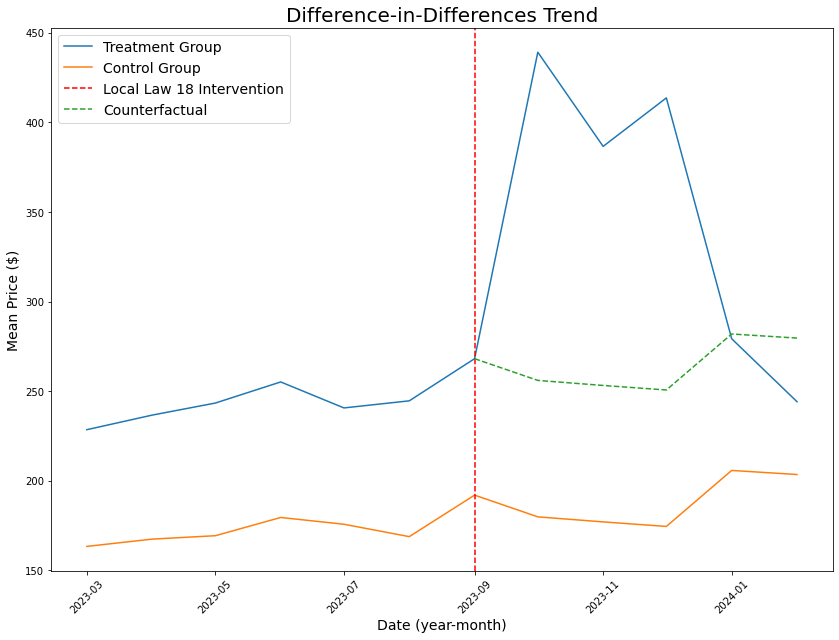

In [120]:
# Find the mean price of the Treatment Group for each month
treatment_group = df_diff[df_diff['treatment'] == 1]
treatment_mean = treatment_group.groupby('date')['price'].mean()

# Find the mean price of the Control Group for each month
control_group = df_diff[df_diff['treatment'] == 0]
control_mean = control_group.groupby('date')['price'].mean()

# Indicate the treatment date and ensure it is in datetime format
treatment_start = pd.to_datetime('2023-09')

# Find the Counterfactual to plot after the treatment_start
counterfactual = df_diff[(df_diff['treatment'] == 0) & (df_diff['date'] >= '2023-09')]
counterfactual_mean = counterfactual.groupby('date')['price'].mean()

# Filter the DataFrame for the control and treatment group and the date '2023-09'
treatment_group_september = df_diff[(df_diff['treatment'] == 1) & (df_diff['date'] == '2023-09')]
mean_price_september_treatment = treatment_group_september['price'].mean()

control_group_september = df_diff[(df_diff['treatment'] == 0) & (df_diff['date'] == '2023-09')]
mean_price_september_control = control_group_september['price'].mean()

# Calculate the difference of the mean price to plot the Counterfactual of the treatment group
difference = mean_price_september_treatment - mean_price_september_control

# Plot the trend for the treatment group, control group, and counterfactual control group
plt.figure(figsize=(14, 10))
sns.lineplot(x=treatment_mean.index, y=treatment_mean.values, label='Treatment Group')
sns.lineplot(x=control_mean.index, y=control_mean.values, label='Control Group')
plt.axvline(x=treatment_start, color='red', linestyle='--', label='Local Law 18 Intervention')
sns.lineplot(x=counterfactual_mean.index, y=difference + counterfactual_mean,
             label='Counterfactual', linestyle='--')
plt.title('Difference-in-Differences Trend', fontsize=20)
plt.xlabel('Date (year-month)', fontsize=14)
plt.ylabel('Mean Price ($)', fontsize=14)
plt.legend(fontsize=14, loc=2)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()


The graph above provides a visual representation to assess the effectiveness of the intervention and the validity of the DiD approach. Prior to the intervention period, both the treatment and control groups are expected to follow a parallel trend, indicating that the Mean Price for both groups changes at a similar rate over time. Any noticeable discrepancies in the trends indicate issues with the parallel trends assumption for a DiD Analysis.

**Upon observation, small discrepencies before intervention are shown above. This may be caused by:**
* **the imbalance of the distribution of the treatment group and control group.**

* **the data being used. DiD Analysis is performed with panel data (longitudinal), but the data in this study is repeated cross-sectional data.**

* **missing prices being replaced with the mean price. This data manipulation may have affected the parallel trend assumption.**

The Mean Price of the control group is lower than those of the treatment group. A potential reason for this difference is that hosts offer a better unit rate per night for the longer minimum stay. Comparing the treatment and control groups post-intervention reveals the treatment effect, usually measured as the difference in the changes observed in the treatment group compared to the counterfactual.

In [121]:
# Estimate the DiD model
X = df_diff[['treatment', 'post', 'treatment_post']]
X = sm.add_constant(X)
y = df_diff['price'] 
model = sm.OLS(y, X).fit()

print(model.summary(title='Difference-in-Differences (DiD) Regression Results'))

              Difference-in-Differences (DiD) Regression Results              
Dep. Variable:                  price   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     408.6
Date:                Tue, 07 May 2024   Prob (F-statistic):          6.36e-265
Time:                        23:53:43   Log-Likelihood:            -2.4920e+06
No. Observations:              319968   AIC:                         4.984e+06
Df Residuals:                  319964   BIC:                         4.984e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            174.8839      1.680    104.

The treatment coefficient (67.8111) suggests that, on average, short-term  Airbnb listings are $67.81 higher than long-term Airbnb listings, holding the other variables constant.

The post coefficient (13.1949) suggests that prices of Airbnb listings increased on average an additional $13.19 on average after September 2023, holding the other variables constant.

The treatment_post coefficient (90.97) suggests that short-term Airbnb listings on average are higher in price by $47.75 on average after the implementation of Local Law 18 in September 2023 compared to long-term Airbnb listings before September 2023, holding the other variables constant.

**All of the coefficients are statistically significant. The statistical significance of the `treatment_post` coefficient highlight the significance of factoring time variables and policy interventions when analyzing the effect of pricing within the Airbnb market concerning the enforcement of Local Law 18.**